In [1]:
%%capture
!pip install gdown contextily

In [2]:
import gdown

import pandas as pd
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import contextily as ctx

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from geopy.distance import geodesic

In [3]:
%%capture

ROUTE_GPX = 'route.gpx'
ROUTE_GPX_URL = 'https://drive.google.com/file/d/1-kx84-fNAOuDWSdVEYU_DjP4Om0yHnaD/view?usp=sharing'
gdown.download(ROUTE_GPX_URL, ROUTE_GPX, quiet=True, fuzzy=True)

In [4]:
def parse_gpx(filepath):
    ns = '{http://www.topografix.com/GPX/1/1}'
    root = ET.parse(filepath).getroot()

    data = {
        'lat': [float(pt.get('lat')) for trk in root.findall(f".//{ns}trk")
                for seg in trk.findall(f"{ns}trkseg")
                for pt in seg.findall(f"{ns}trkpt")],
        'lon': [float(pt.get('lon')) for trk in root.findall(f".//{ns}trk")
                for seg in trk.findall(f"{ns}trkseg")
                for pt in seg.findall(f"{ns}trkpt")]
    }

    return pd.DataFrame(data)

df = parse_gpx(ROUTE_GPX)
df.head()

,lat,lon
0,20.993817,105.868370
1,20.993691,105.868892
2,20.993616,105.869054
3,20.993609,105.869099
4,20.993607,105.869111


In [5]:
def bucketize_column(series, n_buckets):
    quantiles = series.quantile(np.linspace(0, 1, n_buckets+1))
    labels = [f'Bucket_{i}' for i in range(1, len(quantiles))]
    return (pd.cut(series, bins=quantiles, labels=labels, include_lowest=True), quantiles)

df['lat_bucket'], lat_quantiles = bucketize_column(df['lat'], n_buckets=30)
df['lon_bucket'], lon_quantiles = bucketize_column(df['lon'], n_buckets=30)

lat_encoder, lon_encoder = LabelEncoder(), LabelEncoder()

df['lat_encoded'] = lat_encoder.fit_transform(df['lat_bucket'])
df['lon_encoded'] = lon_encoder.fit_transform(df['lon_bucket'])

df.head()

,lat,lon,lat_bucket,lon_bucket,lat_encoded,lon_encoded
0,20.993817,105.868370,Bucket_15,Bucket_18,6,9
1,20.993691,105.868892,Bucket_15,Bucket_20,6,12
2,20.993616,105.869054,Bucket_15,Bucket_22,6,14
3,20.993609,105.869099,Bucket_15,Bucket_23,6,15
4,20.993607,105.869111,Bucket_15,Bucket_23,6,15


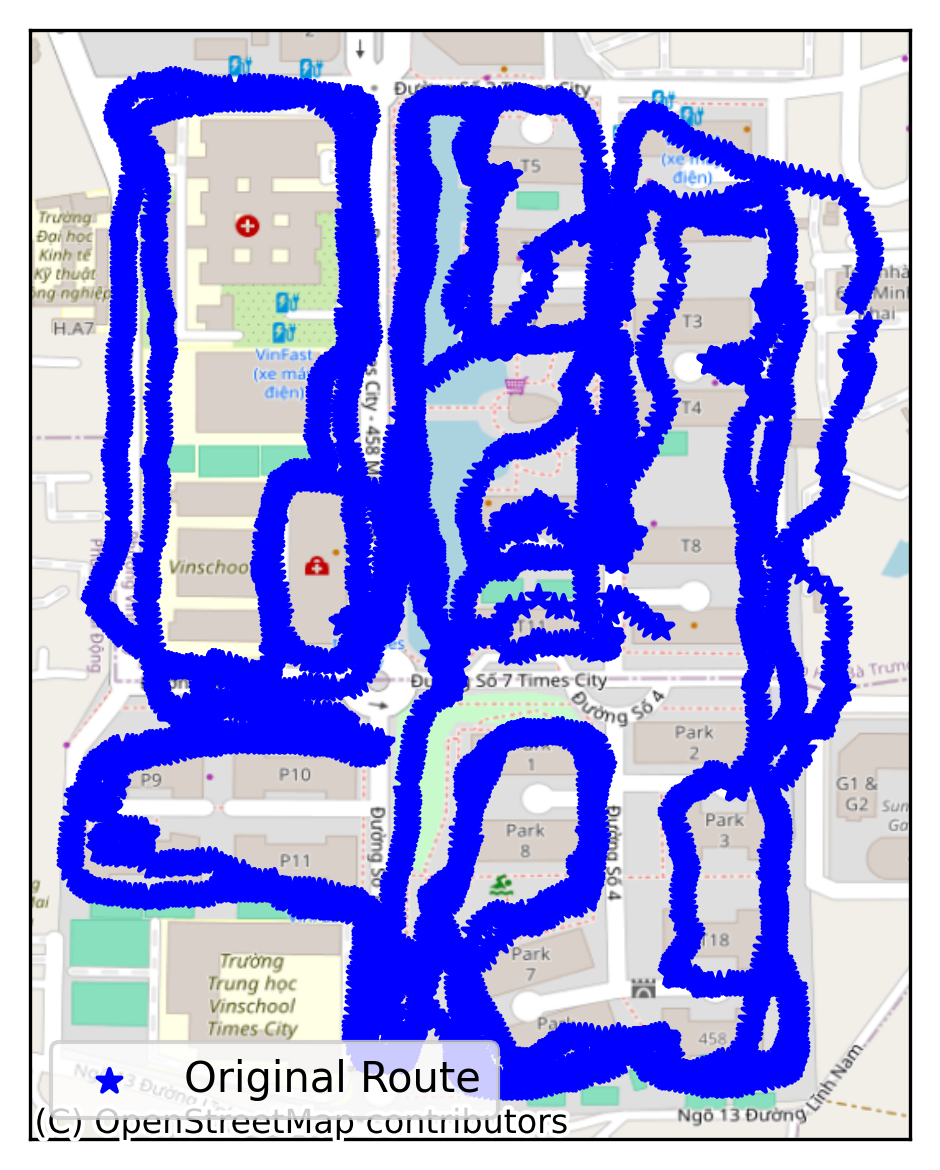

In [8]:
def plot(df, label, color='blue'):
    plt.figure(dpi=300)
    plt.scatter(df['lon'], df['lat'], color=color, marker='*', label=label)
    plt.gca().set_aspect('equal', adjustable='box')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()

plot(df, 'Original Route')

<ipython-input-9-335a807f3428>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bins_df = df.groupby(['lat_bucket', 'lon_bucket']).agg({


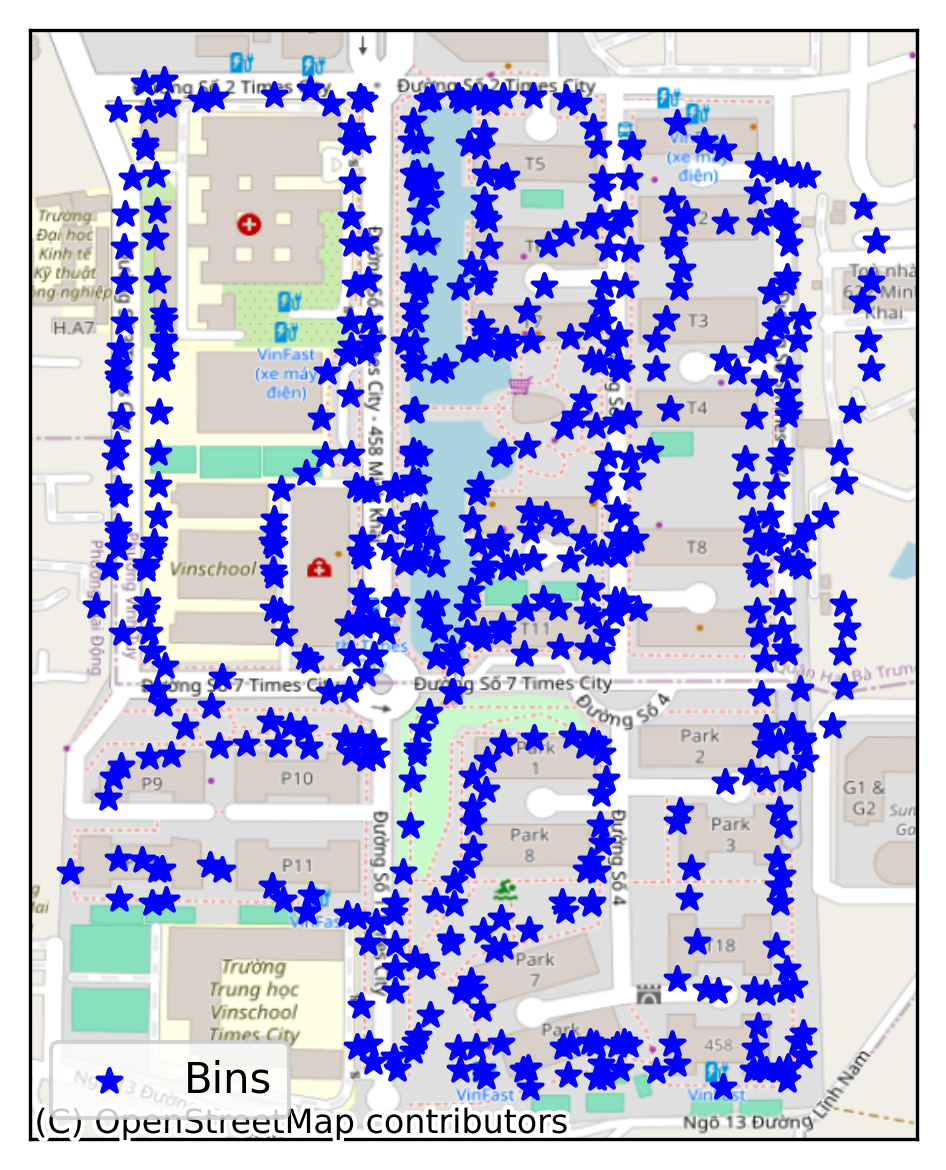

In [9]:
bins_df = df.groupby(['lat_bucket', 'lon_bucket']).agg({
    'lat': 'first',
    'lon': 'first'
}).reset_index()
plot(bins_df, 'Bins')

In [10]:
bins_df.shape

(900, 4)

In [12]:
features = df[['lat_encoded', 'lon_encoded']]
X = features.to_numpy()
y1 = df['lat_encoded']
y2 = df['lon_encoded']

X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=42)

input_layer = Input(shape=(X_train.shape[1],))
hidden = Dense(3, activation='relu')(input_layer)

lat_output = Dense(len(lat_encoder.classes_), activation='softmax', name='lat_output')(hidden)
lon_output = Dense(len(lon_encoder.classes_), activation='softmax', name='lon_output')(hidden)

model = Model(inputs=input_layer, outputs=[lat_output, lon_output])

# Compile the model with separate loss functions for each output
model.compile(optimizer='adam',
              loss={'lat_output': 'sparse_categorical_crossentropy',
                    'lon_output': 'sparse_categorical_crossentropy'},
              metrics={'lat_output': 'accuracy', 'lon_output': 'accuracy'})

# Train the model
history = model.fit(
    X_train,
    {'lat_output': y1_train, 'lon_output': y2_train},
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - lat_output_accuracy: 0.0240 - lon_output_accuracy: 0.0358 - loss: 11.4032 - val_lat_output_accuracy: 0.0165 - val_lon_output_accuracy: 0.0275 - val_loss: 8.9306
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lat_output_accuracy: 0.0247 - lon_output_accuracy: 0.0321 - loss: 8.3089 - val_lat_output_accuracy: 0.0468 - val_lon_output_accuracy: 0.0261 - val_loss: 7.5190
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lat_output_accuracy: 0.0330 - lon_output_accuracy: 0.0354 - loss: 7.2398 - val_lat_output_accuracy: 0.0564 - val_lon_output_accuracy: 0.0481 - val_loss: 7.0006
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lat_output_accuracy: 0.0408 - lon_output_accuracy: 0.0699 - loss: 6.8768 - val_lat_output_accuracy: 0.0550 - val_lon_output_accuracy: 0.0509 - val_loss: 6.7891
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lat_output_accuracy: 0.0472 - lon_output_accuracy: 0.0644 - loss: 6.6952 - val_lat_output_accu

In [13]:
def predict_next(
    lat,
    lon,
    lat_quantiles,
    lon_quantiles,
    lat_encoder,
    lon_encoder,
    model,
    bins_df,
):
    new_data = pd.DataFrame({
        'lat': [lat],
        'lon': [lon],
    })

    lat_labels = [f'Bucket_{i}' for i in range(1, len(lat_quantiles))]
    lon_labels = [f'Bucket_{i}' for i in range(1, len(lon_quantiles))]

    new_data['lat_bucket'] = pd.cut(new_data['lat'], bins=lat_quantiles, labels=lat_labels, include_lowest=True)
    new_data['lon_bucket'] = pd.cut(new_data['lon'], bins=lon_quantiles, labels=lon_labels, include_lowest=True)

    new_data['lat_encoded'] = lat_encoder.transform(new_data['lat_bucket'])
    new_data['lon_encoded'] = lon_encoder.transform(new_data['lon_bucket'])

    X_new = new_data[['lat_encoded', 'lon_encoded']].to_numpy()
    predictions = model.predict(X_new)

    lat_bucket_predicted = lat_encoder.inverse_transform([np.argmax(predictions[0][0])])[0]
    lon_bucket_predicted = lon_encoder.inverse_transform([np.argmax(predictions[1][0])])[0]

    bin_df = bins_df[(bins_df['lat_bucket'] == lat_bucket_predicted) & (bins_df['lon_bucket'] == lon_bucket_predicted)]

    # print(f"Input: {lat}, {lon}")
    # print(f"Predicted: {bin_df.iloc[0]['lat']} / {bin_df.iloc[0]['lon']}")

    return bin_df.iloc[0]['lat'], bin_df.iloc[0]['lon']

predict_next(
    20.993691,
    105.868892,
    lat_quantiles,
    lon_quantiles,
    lat_encoder,
    lon_encoder,
    model,
    bins_df,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


(20.99389590424486, 105.86906965551019)

In [14]:
def haversine_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def predict_over_route():
    predictions = []
    cumulative_distance = 0

    for index, row in df.iterrows():
        lat, lon = row['lat'], row['lon']

        next_lat, next_lon = predict_next(
            lat,
            lon,
            lat_quantiles,
            lon_quantiles,
            lat_encoder,
            lon_encoder,
            model,
            bins_df,
        )
        if pd.isna(next_lat) or pd.isna(next_lon):
          continue

        dist = haversine_distance(lat, lon, next_lat, next_lon)
        cumulative_distance += dist

        print(f"{index} | Current: ({lat:.6f}, {lon:.6f}) | "
              f"Predicted: ({next_lat:.6f}, {next_lon:.6f}) | "
              f"Distance : {cumulative_distance:.2f} m")

        if index > 500:
          break

        predictions.append([next_lat, next_lon])

    return predictions

predicted_path = predict_over_route()

predicted_df = pd.DataFrame(predicted_path, columns=['lat', 'lon'])
print(predicted_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0 | Current: (20.993817, 105.868370) | Predicted: (20.993910, 105.868971) | Distance : 63.30 m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1 | Current: (20.993691, 105.868892) | Predicted: (20.993896, 105.869070) | Distance : 92.60 m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2 | Current: (20.993616, 105.869054) | Predicted: (20.993609, 105.869099) | Distance : 97.40 m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3 | Current: (20.993609, 105.869099) | Predicted: (20.993589, 105.870484) | Distance : 241.44 m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4 | Current: (20.993607, 105.869111) | Predicted: (20.993589, 105.870484) | Distance : 384.19 m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5 | Current: (20.993592, 105.869147) | Predicted: (20.993589, 105.870484) | Distance : 523.29 m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6 | Current: (20.993556, 105.869193) | Predicted: (20.993278, 105.870478) | Distance : 660.39 m
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7 | Current: (20.993511, 10

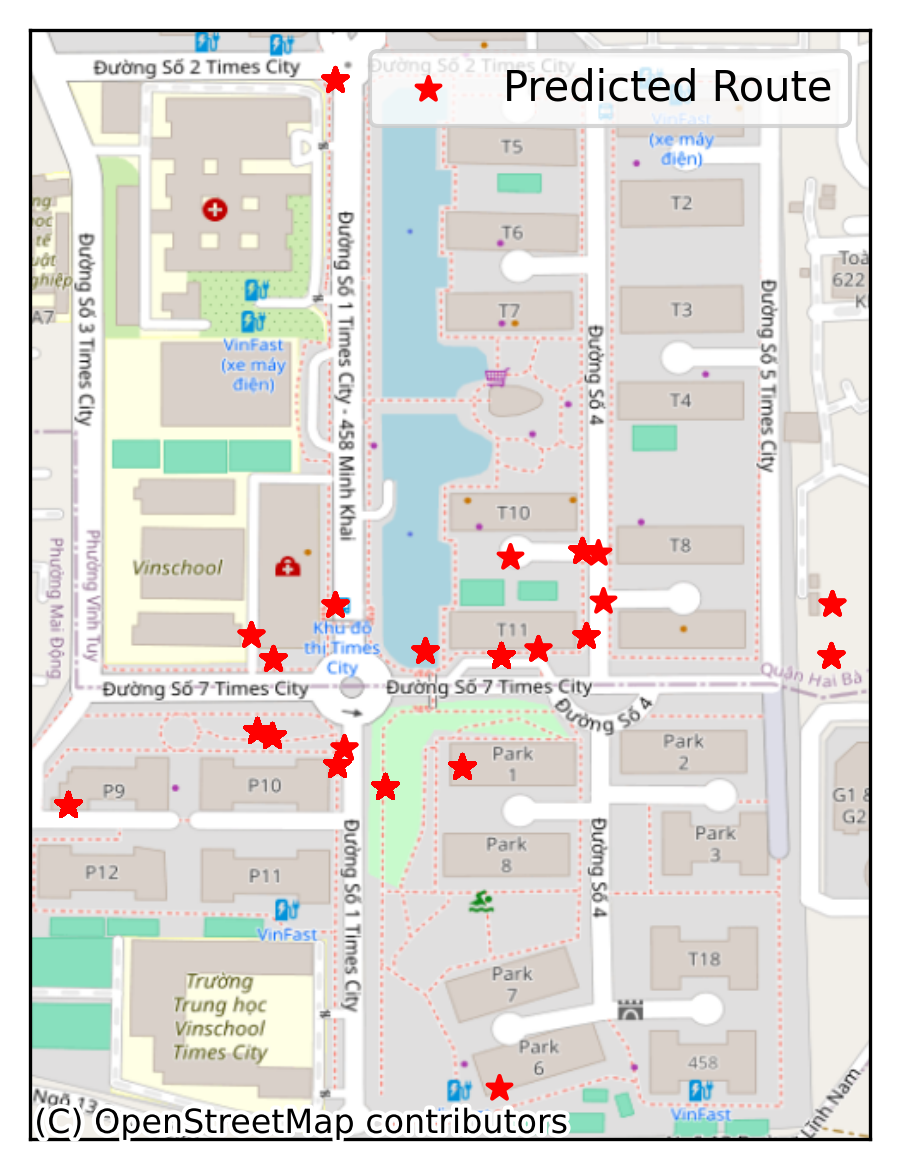

In [15]:
plot(predicted_df, 'Predicted Route', color='red')

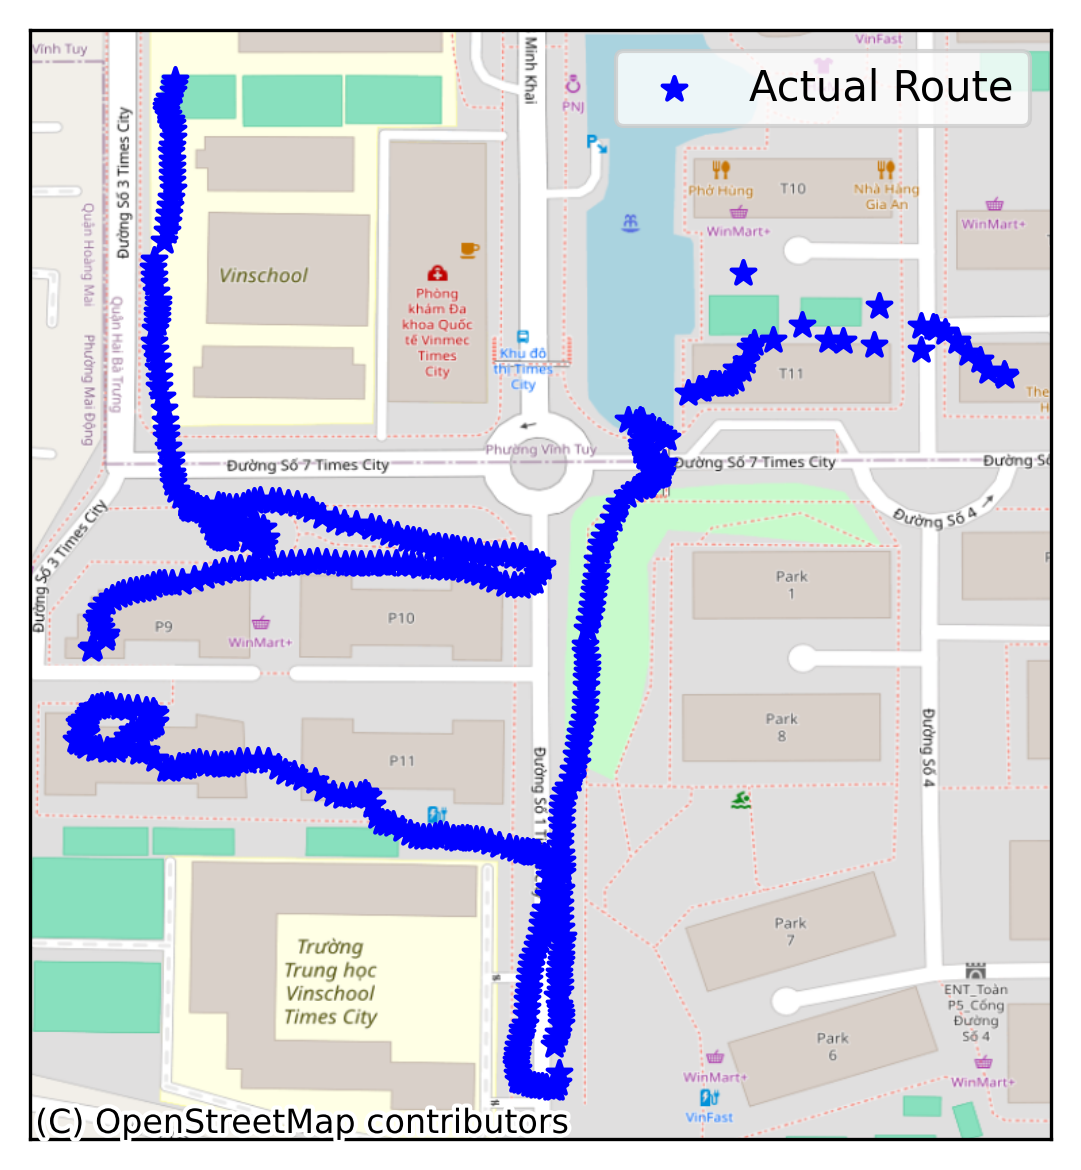

In [16]:
plot(df.iloc[:500], 'Actual Route')